## NLP CW - Michelle Lo, Hetty Symes, Evelyn Nutton

RoBERTa base model

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import transformers
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline, RobertaModel, AutoTokenizer, AutoModelForSequenceClassification, AdamW, DataCollatorWithPadding, get_scheduler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, RandomOverSampler
import nlpaug.augmenter.word as naw
import sacremoses
import nltk
import math
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /homes/en120/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /homes/en120/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:

train_df = pd.read_csv("train_dev_data/train_set.csv")
test_df = pd.read_csv("train_dev_data/dev_set.csv")


### Data Augmentation via Back Translation

In [6]:
back_aug = naw.BackTranslationAug(
    from_model_name='Helsinki-NLP/opus-mt-en-de',
    to_model_name='Helsinki-NLP/opus-mt-de-en',
    device=device
)
underrep = train_df[train_df['label'] == 1]
underrep_augment = underrep.copy().dropna()
underrep_augment_data = back_aug.augment(underrep_augment["text"].to_list())
underrep_augment_data = pd.DataFrame([t for t in underrep_augment_data if type(t) != float])
underrep_augment[["text"]] = pd.DataFrame(underrep_augment_data)
print(underrep["text"].to_list()[0])
print(underrep_augment_data.to_list()[0])
train_df_augment = pd.concat([train_df,underrep_augment])

print(train_df['label'].value_counts())
print(train_df_augment['label'].value_counts())

train_df = train_df_augment
train_df.head()

KeyboardInterrupt: 

### Over Sampling

In [ ]:
print(train_df['label'].value_counts())

X_train = train_df[['text']]  # Feature columns
y_train = train_df['label']  # Target column

# Initialize the random oversampler
ros = RandomOverSampler(random_state=42)

# Apply oversampling
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


                                                text  label
0  We 're living in times of absolute insanity , ...      0
1  In Libya today , there are countless number of...      0
2  "White House press secretary Sean Spicer said ...      0
3  Council customers only signs would be displaye...      0
4  """ Just like we received migrants fleeing El ...      0
label
0    7581
1    7581
Name: count, dtype: int64


,text,label
0,"We 're living in times of absolute insanity , ...",0
1,"In Libya today , there are countless number of...",0
2,"""White House press secretary Sean Spicer said ...",0
3,Council customers only signs would be displaye...,0
4,""""""" Just like we received migrants fleeing El ...",0


### Combining Resampled and Augmented Data into New Data Frame

In [6]:
# Update the dataset with the resampled values
train_df = pd.DataFrame(X_resampled, columns=X_train.columns)
train_df['label'] = y_resampled


# Verify the oversampling result
print(train_df['label'].value_counts())
train_df.head()

label
0    7581
1    7581
Name: count, dtype: int64


,text,label
0,"We 're living in times of absolute insanity , ...",0
1,"In Libya today , there are countless number of...",0
2,"""White House press secretary Sean Spicer said ...",0
3,Council customers only signs would be displaye...,0
4,""""""" Just like we received migrants fleeing El ...",0


### Loading the Roberta Base Model

In [7]:
# Load the pre-trained model
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, truncation=True, do_lower_case=True)
pretrained_model = RobertaModel.from_pretrained(checkpoint, num_labels=2)
pretrained_model = pretrained_model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### PCLData class

In [8]:
# Class for the data
class PCLData(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = data
        self.text = self.data.text
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [9]:
MAX_LEN = 256
# LEARNING_RATE = 1e-05

In [15]:
print("TRAIN Dataset: {}".format(train_df.shape))
print("TEST Dataset: {}".format(test_df.shape))
train_dataset = PCLData(train_df, tokenizer, MAX_LEN)
test_dataset = PCLData(test_df, tokenizer, MAX_LEN)

test_params = {'batch_size': 4, 'shuffle': True, 'num_workers': 0}
testing_loader = DataLoader(test_dataset, **test_params)

# train_params = {'batch_size': 16,
#                 'shuffle': True,
#                 'num_workers': 0
#                 }

# test_params = {'batch_size': 4,
#                 'shuffle': True,
#                 'num_workers': 0
#                 }

# training_loader = DataLoader(train_dataset, **train_params)
# testing_loader = DataLoader(test_dataset, **test_params)

TRAIN Dataset: (15162, 2)
TEST Dataset: (2094, 7)


### Fine Tuning Model

In [11]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = pretrained_model
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [12]:
model = RobertaClass()
model.to(device)

RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

### Alternative Loss - Self Adjusting Dice Loss
Taken from the unofficial Pytorch implementation of https://arxiv.org/abs/1911.02855, which can be founds here https://github.com/fursovia/self-adj-dice.


In [13]:
# Loss

# Taken from the SelfAdjDiceLoss python module source code which cannot be imported regularly due to pytorch compatibility issues
class SelfAdjDiceLoss(torch.nn.Module):
    r"""
    Creates a criterion that optimizes a multi-class Self-adjusting Dice Loss
    ("Dice Loss for Data-imbalanced NLP Tasks" paper)

    Args:
        alpha (float): a factor to push down the weight of easy examples
        gamma (float): a factor added to both the nominator and the denominator for smoothing purposes
        reduction (string): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed.

    Shape:
        - logits: `(N, C)` where `N` is the batch size and `C` is the number of classes.
        - targets: `(N)` where each value is in [0, C - 1]
    """

    def __init__(self, alpha: float = 1.0, gamma: float = 1.0, reduction: str = "mean") -> None:
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        probs = torch.softmax(logits, dim=1)
        print(logits.shape)
        probs = torch.gather(probs, dim=1, index=targets.unsqueeze(1))

        probs_with_factor = ((1 - probs) ** self.alpha) * probs
        loss = 1 - (2 * probs_with_factor + self.gamma) / (probs_with_factor + 1 + self.gamma)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        elif self.reduction == "none" or self.reduction is None:
            return loss
        else:
            raise NotImplementedError(f"Reduction `{self.reduction}` is not supported.")

In [14]:

# Creating the loss function and optimizer
criterion = SelfAdjDiceLoss()
# loss_function = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(params =  model.parameters(), lr=LEARNING_RATE)

def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [27]:

def train(model, epoch, optimizer, training_loader, scheduler=None):
    tr_loss = 0; n_correct = 0; steps = 0; seen = 0
    model.train()
    for i,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        preds = model(ids, mask, token_type_ids)
        loss = loss_function(preds, targets)
        tr_loss += loss.item()
        _, pred_labels = torch.max(preds.data, dim=1)
        n_correct += calcuate_accuracy(pred_labels, targets)

        steps += 1
        seen+=targets.size(0)
        
        if i%5000==0:
            curr_loss = tr_loss/steps
            curr_acc = (n_correct*100)/seen 
            print(f"Training Loss per 5000 steps: {curr_loss}")
            print(f"Training Accuracy per 5000 steps: {curr_acc}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

    print(f'Total Accuracy for Epoch {epoch}: {(n_correct*100)/seen}')
    epoch_loss = tr_loss/steps
    epoch_accu = (n_correct*100)/seen
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [19]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; steps=0; seen=0
    preds_model = torch.tensor([]).to(device); targets_model = torch.tensor([]).to(device)

    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            preds = model(ids, mask, token_type_ids).squeeze()
            
            _, pred_labels = torch.max(preds.data, dim=1)
            n_correct += calcuate_accuracy(pred_labels, targets)

            steps += 1
            seen+=targets.size(0)

            preds_model = torch.cat((preds_model, pred_labels))
            targets_model = torch.cat((targets_model, targets))
            
    epoch_accu = (n_correct*100)/seen

    
    
    return epoch_accu, preds_model, targets_model

acc, preds, targets = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

0it [00:00, ?it/s]/vol/bitbucket/mwl21/nlp-venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2690: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
524it [00:18, 28.58it/s]

Accuracy on test data = 27.27%


# Hyperparameter tuning

In [24]:
def train_with_hyperparameters(learning_rate, batch_size, epochs, use_scheduler=True, gamma=0.9):
    train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 0}
    training_loader = DataLoader(train_dataset, **train_params)
    model = RobertaClass().to(device)
    optimizer = torch.optim.AdamW(params =  model.parameters(), lr=learning_rate)

    scheduler = None
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)
    

    for epoch in range(epochs):
        train(model, epoch, optimizer, training_loader, scheduler)

    acc, preds, targets = valid(model, testing_loader)
    print("Accuracy on test data = %0.2f%%" % acc)
    print(classification_report(targets.cpu().numpy(), preds.cpu().numpy()))
    

In [ ]:
# Hyperparameters to tune: learning rate and batch size

batch_sizes = [4, 16, 32]
learning_rates = [1e-5, 1e-3, 1e-2]
gamma_rates = [0.3, 0.5, 0.9]


for batch_size in batch_sizes:
    for lr in learning_rates:
        print(f"Batch size {batch_size}, LR {lr}, no scheduler")
        train_with_hyperparameters(lr, batch_size, 5, use_scheduler=False)
        for gamma in gamma_rates:
            print(f"Batch size {batch_size}, LR {lr}, scheduler with gamma {gamma}")
            train_with_hyperparameters(lr, batch_size, 5, use_scheduler=True, gamma=gamma)

In [ ]:
EPOCHS = 5
FINAL_LR = 1e-4
FINAL_TRAIN_BATCH_SIZE = 16
FINAL_GAMMA = 0.9

train_with_hyperparameters(FINAL_LR, FINAL_TRAIN_BATCH_SIZE, EPOCHS)

0it [00:00, ?it/s]/vol/bitbucket/en120/dlenv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2681: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
1it [00:00,  1.31it/s]

Training Loss per 5000 steps: 0.19256092607975006
Training Accuracy per 5000 steps: 93.75


948it [18:48,  1.19s/it]


Total Accuracy for Epoch 0: 97.77733808204722
Training Loss Epoch: 0.06323339307289237
Training Accuracy Epoch: 97.77733808204722


1it [00:00,  3.93it/s]

Training Loss per 5000 steps: 0.013898417353630066
Training Accuracy per 5000 steps: 100.0


948it [10:03,  1.57it/s]

Total Accuracy for Epoch 1: 99.16897506925208
Training Loss Epoch: 0.02566149712084986
Training Accuracy Epoch: 99.16897506925208


# Evaluation

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      1895
         1.0       0.63      0.55      0.58       199

    accuracy                           0.93      2094
   macro avg       0.79      0.76      0.77      2094
weighted avg       0.92      0.93      0.92      2094

Confusion Matrix:
[[1830   65]
 [  90  109]]


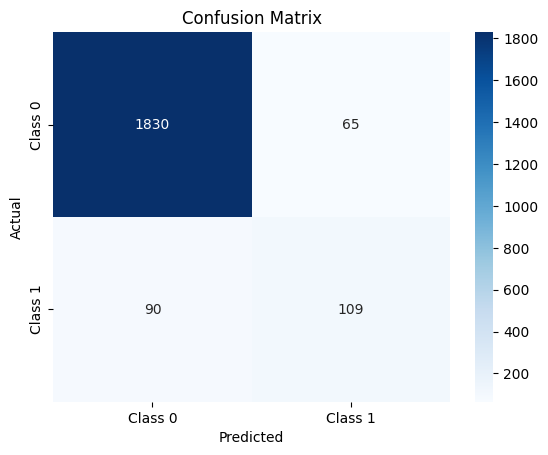

In [30]:
print("Classification Report:")
print(classification_report(targets.cpu().numpy(), preds.cpu().numpy()))

# Confusion matrix
cm = confusion_matrix(targets.cpu().numpy(), preds.cpu().numpy())
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()